In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import numpy as np
from sklearn.cluster import KMeans
import math
from copy import deepcopy

In [26]:
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)

    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    return q_x, scale, zero_point


def dequantize_tensor(q_x, scale, zero_point):
    return scale * (q_x.float() - zero_point)

w = torch.rand(3,4)
print(w)

print(dequantize_tensor(*quantize_tensor(w)))

tensor([[0.1626, 0.2076, 0.4857, 0.8813],
        [0.8368, 0.0530, 0.1879, 0.5520],
        [0.5488, 0.7655, 0.1304, 0.3950]])
tensor([[0.1624, 0.2079, 0.4873, 0.8283],
        [0.8283, 0.0520, 0.1884, 0.5522],
        [0.5490, 0.7666, 0.1299, 0.3963]])


In [55]:
class QuantLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(QuantLinear, self).__init__(in_features, out_features, bias)
        self.quant_flag = False
        self.scale = None
        self.zero_point = None
    
    def linear_quant(self, quantize_bit=8):
        self.weight.data, self.scale, self.zero_point = quantize_tensor(self.weight.data, num_bits=quantize_bit)
        self.quant_flag = True

    def forward(self, x):
        if self.quant_flag == True:
            weight = dequantize_tensor(self.weight, self.scale, self.zero_point)
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
        
            
class QuantConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(QuantConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.quant_flag = False
        self.scale = None
        self.zero_point = None
    
    def linear_quant(self, quantize_bit=8):
        self.weight.data, self.scale, self.zero_point = quantize_tensor(self.weight.data, num_bits=quantize_bit)
        self.quant_flag = True
        
    def forward(self, x):
        if self.quant_flag == True:
            weight = dequantize_tensor(self.weight, self.scale, self.zero_point)
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = QuantConv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = QuantConv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = QuantConv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.linear1 = QuantLinear(7*7*64, 10)
        
    def forward(self, x):
        out = self.maxpool1(self.relu1(self.conv1(x)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = self.relu3(self.conv3(out))
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        return out

    def linear_quant(self, quantize_bit=8):
        # Should be a less manual way to quantize
        # Leave it for the future
        self.conv1.linear_quant(quantize_bit)
        self.conv2.linear_quant(quantize_bit)
        self.conv3.linear_quant(quantize_bit)
        self.linear1.linear_quant(quantize_bit)


In [41]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        total += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, total, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')

In [42]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [49]:
def main():
    epochs = 2
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = ConvNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        _, acc = test(model, device, test_loader)
    
    quant_model = deepcopy(model)
    print('\n')
    print('=='*10)
    print('4 linear bits quantization')
    quant_model.linear_quant(quantize_bit=4)
    _, acc = test(quant_model, device, test_loader)
    
    return model, quant_model

In [50]:
model, quant_model = main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0471, accuracy: 9847/10000 (98%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0252, accuracy: 9917/10000 (99%)


4 linear bits quantization

Test: average loss: 0.0268, accuracy: 9916/10000 (99%)


## 可视化

In [51]:
from matplotlib import pyplot as plt

In [52]:
def plot_weights(model):
    modules = [module for module in model.modules()]
    num_sub_plot = 0
    for i, layer in enumerate(modules):
        if hasattr(layer, 'weight'):
            plt.subplot(221+num_sub_plot)
            w = layer.weight.data
            w_one_dim = w.cpu().numpy().flatten()
            plt.hist(w_one_dim, bins=50)
            num_sub_plot += 1
    plt.show()


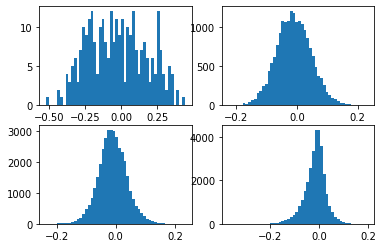

In [53]:
plot_weights(model)

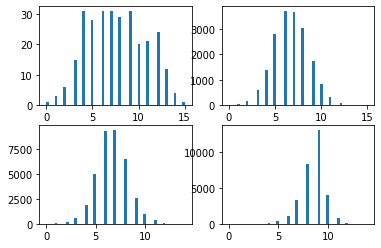

In [54]:
plot_weights(quant_model)